In [1]:
import os, sys, json, time, warnings
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
# Paths (adjust if your layout differs)
ROOT = Path.cwd().parent if (Path.cwd().name == 'src') else Path.cwd()
DATA = ROOT / "data"
SRC  = ROOT / "src"
SUBM = ROOT / "sample_submission"

# Ensure src is importable
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

# Create sample_submission dir if missing
SUBM.mkdir(parents=True, exist_ok=True)

SEED = 1337
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [3]:
# Paths (adjust if your layout differs)
ROOT = Path('/home/pduce/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit')
DATA = ROOT / "data"
SRC  = ROOT / "src"
SUBM = ROOT / "sample_submission"

# Ensure src is importable
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

# Create sample_submission dir if missing
SUBM.mkdir(parents=True, exist_ok=True)

SEED = 1337
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [4]:
# Load dataset files
info_path = DATA / "dataset_info.json"
if info_path.exists():
    info = json.loads(info_path.read_text(encoding="utf-8"))
    print("dataset_info.json loaded. Keys:", list(info.keys()))
    print(json.dumps({k: info[k] for k in ['features','input_len','horizon_len','outputs']}, indent=2))
else:
    print("dataset_info.json not found at", info_path)

# Peek train / x_test
train_path = DATA / "train.pkl"
x_test_path  = DATA / "x_test.pkl"
y_local_path = DATA / "y_test_local.pkl"

train = pd.read_pickle(train_path)
x_test  = pd.read_pickle(x_test_path)
y_test_local = pd.read_pickle(y_local_path)

print("train shape:", train.shape, "| columns:", train.columns.tolist())
print("x_test  shape:", x_test.shape,  "| columns:", x_test.columns.tolist())
print("y_test_local shape:", y_test_local.shape, "| columns:", y_test_local.columns.tolist())

display(train.head(3))
display(x_test.head(3))
display(y_test_local.head(3))

dataset_info.json loaded. Keys: ['freq', 'features', 'input_len', 'horizon_len', 'dtypes', 'outputs', 'sha256']
{
  "features": [
    "close",
    "volume"
  ],
  "input_len": 60,
  "horizon_len": 10,
  "outputs": {
    "train": {
      "columns": [
        "series_id",
        "time_step",
        "close",
        "volume"
      ]
    },
    "x_test": {
      "columns": [
        "window_id",
        "time_step",
        "close",
        "volume"
      ]
    },
    "y_test_local": {
      "columns": [
        "window_id",
        "time_step",
        "close"
      ]
    }
  }
}
train shape: (18331224, 4) | columns: ['series_id', 'time_step', 'close', 'volume']
x_test  shape: (3000000, 4) | columns: ['window_id', 'time_step', 'close', 'volume']
y_test_local shape: (20, 3) | columns: ['window_id', 'time_step', 'close']


,series_id,time_step,close,volume
0,1,0,0.13700,171985.703125
1,1,1,0.13656,85451.398438
2,1,2,0.13647,121151.898438


,window_id,time_step,close,volume
0,1,0,0.1126,24976.0
1,1,1,0.1126,0.0
2,1,2,0.1125,2299.0


,window_id,time_step,close
0,1,0,0.1131
1,1,1,0.1131
2,1,2,0.1130


In [87]:
# Use the sampler logic from src/dataset.py to slice windows
from icaif.dataset import TrainWindowSampler

class WindowsDataset(Dataset):
    """
    Wrap TrainWindowSampler into a PyTorch Dataset.
    Returns:
      X: (60, 2) float32 -> [close, volume]
      y: (10,)  float32 -> future close
    """
    def __init__(self, train_path: str, rolling: bool = True, step_size: int = 1, max_samples: int = None):
        self.sampler = TrainWindowSampler(
            train_path=train_path,
            window=70,
            input_len=60,
            horizon_len=10,
            rolling=rolling,
            step_size=step_size,
            seed=SEED,
        )
        # Materialize (optionally capped) for stable batching
        xs, ys = [], []
        for i, (X, y) in enumerate(self.sampler.iter_windows()):
            xs.append(X.astype(np.float32))
            ys.append(y.astype(np.float32))
            if max_samples is not None and (i + 1) >= max_samples:
                break
        self.X = np.stack(xs, axis=0) if xs else np.zeros((0,60,2), dtype=np.float32)
        self.y = np.stack(ys, axis=0) if ys else np.zeros((0,10), dtype=np.float32)

    def __len__(self):  return len(self.X)
    def __getitem__(self, i):
        return torch.from_numpy(self.X[i]), torch.from_numpy(self.y[i])

# For a quick demo, cap samples. Increase for better quality.
MAX_SAMPLES = None  # set to None to use all windows
train_ds = WindowsDataset(str(train_path), rolling=True, step_size=1, max_samples=MAX_SAMPLES)
len(train_ds), train_ds.X.shape, train_ds.y.shape

(18327774, (18327774, 60, 2), (18327774, 10))

In [88]:
from athenea.stats.regressions import ridge

df_y = pd.DataFrame(train_ds.y).T

df_prices = pd.DataFrame(train_ds.X[:,:,0]).T
df_logrets = np.log(df_prices).diff()
df_volumes = pd.DataFrame(train_ds.X[:,:,1]).T

# FEATURES
df_avg_lr = df_logrets.mean().to_frame()
df_vol_lr = (df_logrets.mul(df_volumes,axis=0)).mean().to_frame()



In [89]:
df_prices = pd.DataFrame(train_ds.X[:,:,0]).T
df_logrets = np.log(df_prices).diff()

In [90]:
train_val_split = 0.8
train_idx = int(train_val_split * len(train_ds))

df_y_train = df_y.iloc[:,:train_idx]
df_y_val = df_y.iloc[:,train_idx:]

df_avg_lr_train = df_avg_lr.iloc[:train_idx]
df_avg_lr_val = df_avg_lr.iloc[train_idx:]

df_vol_lr_train = df_vol_lr.iloc[:train_idx]
df_vol_lr_val = df_vol_lr.iloc[train_idx:]


In [91]:
ridge_results = ridge(
    y = np.log(df_y_train).diff().mean().to_frame(),
    predictors = [df_avg_lr_train, df_vol_lr_train],
    l2 = 0.1
)

ridge_results.info['adj_r2']

,global
14662218,0.000618


In [92]:
df_y_pred = (df_avg_lr_val * ridge_results.betas.iloc[0,0]) + (df_vol_lr_val * ridge_results.betas.iloc[0,1])

for i in range(1,10):
    df_y_pred[i] = df_y_pred[0]

df_y_pred = df_y_pred.cumsum(axis=1)
df_y_pred = df_y_pred.mul(df_prices.iloc[-1].loc[train_idx:],axis=0)

submission_df = df_y_pred.stack().reset_index().rename(columns={0:'pred_close','level_0':'window_id','level_1':'time_step'})

In [93]:
df_x = pd.DataFrame(
    {
        "window_id": np.repeat(np.arange(train_ds.X.shape[0]), train_ds.X.shape[1]),
        "time_step": np.tile(np.arange(train_ds.X.shape[1]), train_ds.X.shape[0]),
        "close": train_ds.X[:,:,0].flatten(),
        "volume": train_ds.X[:,:,1].flatten()
    }
)

df_y = pd.DataFrame(
    {
        "window_id": np.repeat(np.arange(train_ds.y.shape[0]), train_ds.y.shape[1]),
        "time_step": np.tile(np.arange(train_ds.y.shape[1]), train_ds.y.shape[0]),
        "close": train_ds.y.flatten(),
    }
)

target_wids = submission_df["window_id"].unique()

y_true_val = (
        df_y[(df_y["window_id"].isin(target_wids))]
        [["window_id", "time_step", "close"]]
        .copy()
)

x_val = (
        df_x[(df_x["window_id"].isin(target_wids)) & (df_x["time_step"] == 59)]
        [["window_id", "time_step", "close"]]
        .copy()
)

y_true_with_base_val = pd.merge(y_true_val,x_val[['close','window_id']].rename(columns={'close':'base_close'}),on="window_id")


evaluate_all_metrics(
        y_true=y_true_val,
        y_pred=submission_df,
        x_test=x_val,
        y_true_with_base=y_true_with_base_val,
        horizon_step=0,
    )

{'MSE': 125.57435899165819,
 'MAE': 4.1744873282622885,
 'IC': -0.0023896687006384155,
 'IR': -0.34342681619364485,
 'SharpeRatio': 15029672.6296383,
 'MDD': 0.0,
 'VaR': 1.50296726296383e-05,
 'ES': 1.50296726296383e-05}

# Ridge

In [ ]:
"""
Ridge MIMO forecaster for 60→10 minute crypto price paths (enhanced features + options).

Changes vs. your version:
  - Mean-reversion features: zMA at {5,10,20,60}, OU/AR(1) kappa, log half-life, OU residual std
  - HAR-style vol features: RV_5/15/60 (normalized), quarticity (normalized), vol-of-vol_10
  - Momentum features: sum of last {3,5,10} returns
  - Volume features: within-window z-score, max z-score last L, EMA-gap on log-volume
  - Interactions: zV_last × zMA_{10,20}, zV_last × momentum_3
  - Microstructure: last-return vs median-3 "bounce" gap; sign-alternation count; acceleration
  - Optional: target scaling by EWMA vol; mean reconciliation head; sample weighting

Usage unchanged:
  model = RidgeMIMOPriceForecaster(alpha=2.0)
  model.fit(prices60_train, volumes60_train, future_prices10_train)
  yret_pred, yprice_pred = model.predict(prices60_val, volumes60_val)
"""
from __future__ import annotations
from dataclasses import dataclass
from typing import Tuple, Optional, Dict, List

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge


# =============================
# Utility functions (vectorized)
# =============================

def _safe_std(x: np.ndarray, axis: int) -> np.ndarray:
    eps = 1e-12
    s = x.std(axis=axis, ddof=1)
    return np.where(s < eps, eps, s)

def _ewma_last(x: np.ndarray, alpha: float) -> np.ndarray:
    n, T = x.shape
    out = np.empty(n, dtype=float)
    for i in range(n):
        s = 0.0
        for t in range(T):
            s = alpha * x[i, t] + (1.0 - alpha) * s
        out[i] = s
    return out

def _ema_last_from_span(x: np.ndarray, span: int) -> np.ndarray:
    span = max(1, int(span))
    alpha = 2.0 / (span + 1.0)
    return _ewma_last(x, alpha)

def _ewma_vol_last(returns: np.ndarray, halflife: float = 12.0) -> np.ndarray:
    lam = 0.5 ** (1.0 / max(1e-6, halflife))
    alpha = 1.0 - lam
    ewma_sq_last = _ewma_last(returns ** 2, alpha)
    vol_last = np.sqrt(np.maximum(ewma_sq_last, 1e-12))
    return vol_last

def _sign(x: np.ndarray) -> np.ndarray:
    return np.where(x > 0, 1, np.where(x < 0, -1, 0))

def _alt_sign_count_last_m(returns: np.ndarray, m: int = 10) -> np.ndarray:
    n, T = returns.shape
    m = min(m, T)
    out = np.zeros(n, dtype=float)
    if m < 2:
        return out
    for i in range(n):
        r = returns[i, T - m : T]
        s = _sign(r)
        flips = 0
        for k in range(1, len(s)):
            if s[k] != 0 and s[k - 1] != 0 and s[k] != s[k - 1]:
                flips += 1
        out[i] = float(flips)
    return out

def _median_last3(x: np.ndarray) -> np.ndarray:
    """Row-wise median of the last 3 elements (handles short len). x: (n, T)"""
    n, T = x.shape
    out = np.zeros(n, dtype=float)
    k = min(3, T)
    if k == 0:
        return out
    for i in range(n):
        out[i] = np.median(x[i, T - k : T])
    return out

def _rowwise_beta(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Row-wise OLS slope for y ~ beta * x (no intercept).
    x,y: (n, T)
    """
    eps = 1e-12
    xm = x - x.mean(axis=1, keepdims=True)
    ym = y - y.mean(axis=1, keepdims=True)
    num = (xm * ym).sum(axis=1)
    den = (xm * xm).sum(axis=1)
    return num / np.where(den < eps, eps, den)


# =============================
# Feature engineering
# =============================

@dataclass
class FeatureConfig:
    # Mean-reversion anchors
    ema_spans: Tuple[int, int, int, int] = (5, 10, 20, 60)
    vol_halflife: float = 12.0      # EWMA vol halflife (min)
    alt_sign_m: int = 10
    zvol_max_lookback: int = 10

    # HAR / volatility windows
    har_windows: Tuple[int, int, int] = (5, 15, 60)
    volume_ema_span: int = 10

    # Toggles
    use_feature_scaler: bool = True
    target_scaling: str = "ewma_vol"   # {"none", "ewma_vol"}
    sample_weight_mode: str = "none"   # {"none", "inv_vol"}
    reconcile_mean: bool = True        # add scalar mean head and reconcile path


class WindowFeatureBuilder:
    """Builds features from 60-minute windows of price & volume."""

    def __init__(self, config: FeatureConfig = FeatureConfig()):
        self.cfg = config

    @staticmethod
    def _validate_inputs(prices60: np.ndarray, volumes60: np.ndarray) -> None:
        assert prices60.ndim == 2 and volumes60.ndim == 2, "prices60/volumes60 must be 2D"
        n1, T1 = prices60.shape
        n2, T2 = volumes60.shape
        assert n1 == n2, "prices and volumes must have same number of samples"
        assert T1 == 60 and T2 == 60, "expect 60 minutes for prices and volumes"
        if not np.all(prices60 > 0):
            raise ValueError("All prices must be positive to compute log-prices.")

    def build(self, prices60: np.ndarray, volumes60: np.ndarray) -> Tuple[np.ndarray, Dict[str, np.ndarray], List[str]]:
        self._validate_inputs(prices60, volumes60)
        n, T = prices60.shape  # T=60

        logp = np.log(prices60)
        r = np.diff(logp, axis=1)             # (n, 59)
        p_last = prices60[:, -1]
        r_last = r[:, -1]

        # EWMA volatility at end of window
        vol_last = _ewma_vol_last(r, halflife=self.cfg.vol_halflife)
        vol_last = np.where(vol_last < 1e-8, 1e-8, vol_last)

        # ----- Mean-reversion distances: zMA_k -----
        zma_feats, zma_names = [], []
        for k in self.cfg.ema_spans:
            ema_last = _ema_last_from_span(logp, span=k)
            zma = (logp[:, -1] - ema_last) / vol_last
            zma_feats.append(zma)
            zma_names.append(f"zMA_{k}")
        zma_mat = np.stack(zma_feats, axis=1)  # (n, len(spans))

        # ----- OU/AR(1) proxy within window: r_t ≈ -kappa * dev_{t-1} -----
        # dev_{t-1} is deviation from EMA_60 (as stationary anchor)
        ema60_full_last = _ema_last_from_span(logp, span=60)
        # build dev series for all t within each row
        # We need dev_{t-1} aligned to r_t → use dev[:, :-1]
        ema60_series = np.zeros_like(logp)
        # rebuild full EMA series cheaply via cumulative recursion per row
        # (fall back: approximate with trailing ema_last repeated; EMA slope dominates recent points)
        # For simplicity: use logp - last EMA as approximate dev across window:
        # This treats dev constant = (logp - ema_last), which is acceptable as a low-cost proxy.
        # If you want an exact per-step EMA series, compute it with a loop per row (slower).
        dev = logp - ema60_full_last[:, None]
        x_lag = dev[:, :-1]                 # (n, 59)
        y_ret = r                            # (n, 59)
        beta = _rowwise_beta(x_lag, y_ret)   # slope for y ~ beta*x
        kappa = np.maximum(0.0, -beta)       # enforce mean-reversion sign
        hl = np.log(2.0) / np.maximum(kappa, 1e-8)
        log_hl = np.log(np.clip(hl, 1e-3, 1e6))
        # residual std
        y_hat = beta[:, None] * x_lag
        resid = y_ret - y_hat
        ou_resid_std = np.sqrt(np.mean(resid**2, axis=1))

        # ----- HAR-like volatility summaries (normalized) -----
        def rv_k(k: int) -> np.ndarray:
            k = min(k, r.shape[1])
            return np.sum(r[:, -k:] ** 2, axis=1)

        RV5, RV15, RV60 = [rv_k(k) for k in self.cfg.har_windows]
        eps = 1e-12
        RV60_safe = np.where(RV60 < eps, eps, RV60)
        rv5n = RV5 / RV60_safe
        rv15n = RV15 / RV60_safe
        # quarticity normalized by RV60^2
        quart60 = np.sum(r ** 4, axis=1)
        qn = quart60 / np.maximum(RV60_safe**2, eps)
        # vol-of-vol over last 10 mins
        k10 = min(10, r.shape[1])
        vov10 = r[:, -k10:].std(axis=1, ddof=1) / vol_last

        # ----- Momentum blocks -----
        def mom_k(k: int) -> np.ndarray:
            k = min(k, r.shape[1])
            return np.sum(r[:, -k:], axis=1)
        m3, m5, m10 = mom_k(3), mom_k(5), mom_k(10)

        # ----- Volume features (within-window standardization) -----
        lv = np.log1p(volumes60)
        lv_mean = lv.mean(axis=1, keepdims=True)
        lv_std = _safe_std(lv, axis=1).reshape(-1, 1)
        zV = (lv - lv_mean) / lv_std
        zV_last = zV[:, -1]
        zV_max_lastL = zV[:, -self.cfg.zvol_max_lookback :].max(axis=1)
        # EMA gap on log-volume
        lv_ema_gap = (lv[:, -1] - _ema_last_from_span(lv, self.cfg.volume_ema_span).reshape(-1)) / lv_std.reshape(-1)

        # ----- Lagged returns (last 10) -----
        L = min(10, r.shape[1])
        lags = np.zeros((n, 10), dtype=float)
        for i in range(n):
            lags_i = r[i, -L:][::-1]
            lags[i, :L] = lags_i
        lag_names = [f"r_lag_{k+1}" for k in range(10)]

        # ----- Multi-scale window returns (2,5,10) -----
        def multi_ret(k: int) -> np.ndarray:
            if T - k - 1 < 0:
                return np.zeros(n)
            return logp[:, -1] - logp[:, -1 - k]
        r2 = multi_ret(2)
        r5w = multi_ret(5)
        r10w = multi_ret(10)

        # ----- Microstructure: acceleration, bounce gap, sign alternations -----
        accel = r[:, -1] - (r[:, -2] if r.shape[1] >= 2 else 0.0)
        med3 = _median_last3(r)
        bounce3_gap = r_last - med3
        altc = _alt_sign_count_last_m(r, m=self.cfg.alt_sign_m)

        # ----- Interactions -----
        # volume-conditioned MR / momentum
        zma10 = zma_mat[:, list(self.cfg.ema_spans).index(10)] if 10 in self.cfg.ema_spans else zma_mat[:, 0]
        zma20 = zma_mat[:, list(self.cfg.ema_spans).index(20)] if 20 in self.cfg.ema_spans else zma_mat[:, 0]
        inter1 = zV_last * zma10
        inter2 = zV_last * zma20
        inter3 = zV_last * m3
        inter4 = zV_last * r_last  # keep yours

        # ----- Assemble feature matrix -----
        X = np.concatenate(
            [
                lags,                                      # 10
                np.stack([r2, r5w, r10w], axis=1),         # +3
                zma_mat,                                   # +4
                np.stack([kappa, log_hl, ou_resid_std], axis=1),         # +3
                np.stack([rv5n, rv15n, qn, vov10], axis=1),              # +4
                np.stack([m3, m5, m10], axis=1),                          # +3
                np.stack([zV_last, zV_max_lastL, lv_ema_gap], axis=1),    # +3
                np.stack([accel, bounce3_gap, altc], axis=1),             # +3
                np.stack([inter1, inter2, inter3, inter4], axis=1),       # +4
            ],
            axis=1,
        )

        feature_names = (
            lag_names
            + ["r_win_2", "r_win_5", "r_win_10"]
            + [f"zMA_{k}" for k in self.cfg.ema_spans]
            + ["ou_kappa", "ou_log_half_life", "ou_resid_std"]
            + ["rv5_norm", "rv15_norm", "quart_norm", "volofvol_10"]
            + ["mom_3", "mom_5", "mom_10"]
            + ["zV_last", "zV_max_lastL", "lv_ema_gap"]
            + ["accel", "bounce3_gap", "alt_sign_count_last_m"]
            + ["zV_x_zMA10", "zV_x_zMA20", "zV_x_mom3", "zV_x_r_last"]
        )

        aux = {
            "p_last": p_last,
            "vol_last": vol_last,
            "r_last": r_last,
        }
        return X, aux, feature_names


# =============================
# Ridge MIMO forecaster
# =============================

class RidgeMIMOPriceForecaster:
    def __init__(
        self,
        alpha: float = 1.0,
        feature_config: FeatureConfig = FeatureConfig(),
        shrink_alpha: float = 0.0,      # optional uniform shrink on predicted returns (0..0.3)
    ):
        self.alpha = alpha
        self.feature_builder = WindowFeatureBuilder(feature_config)
        self.cfg = feature_config
        self.shrink_alpha = float(shrink_alpha)

        self.scaler: Optional[StandardScaler] = None
        self.model: Optional[Ridge] = None
        self.model_mean: Optional[Ridge] = None  # scalar mean head (optional)
        self.feature_names_: Optional[List[str]] = None

    @staticmethod
    def _targets_from_prices(prices60: np.ndarray, future_prices10: np.ndarray) -> np.ndarray:
        if future_prices10.ndim != 2 or future_prices10.shape[1] != 10:
            raise ValueError("future_prices10 must have shape (n_samples, 10)")
        logp_last = np.log(prices60[:, -1])
        logp_future = np.log(future_prices10)
        base = logp_last[:, None]
        yret = np.diff(np.concatenate([base, logp_future], axis=1), axis=1)
        return yret  # (n,10)

    def fit(self, prices60: np.ndarray, volumes60: np.ndarray, future_prices10: np.ndarray) -> "RidgeMIMOPriceForecaster":
        X, aux, feat_names = self.feature_builder.build(prices60, volumes60)
        self.feature_names_ = feat_names
        y = self._targets_from_prices(prices60, future_prices10)  # (n,10)

        # --- optional target scaling by local EWMA vol (stabilizes heteroskedasticity) ---
        if self.cfg.target_scaling == "ewma_vol":
            scale = aux["vol_last"][:, None]
            y_train = y / scale
            y_mean = y_train.mean(axis=1)
        else:
            y_train = y
            y_mean = y.mean(axis=1)

        # Feature scaling
        self.scaler = StandardScaler() if self.cfg.use_feature_scaler else None
        Xs = self.scaler.fit_transform(X) if self.scaler else X

        # Sample weights (optional)
        sample_weight = None
        if self.cfg.sample_weight_mode == "inv_vol":
            sample_weight = 1.0 / aux["vol_last"]
            # normalize for numerical stability
            sample_weight = sample_weight / np.mean(sample_weight)

        # Multi-output Ridge
        self.model = Ridge(alpha=self.alpha, fit_intercept=True, random_state=42)
        self.model.fit(Xs, y_train, sample_weight=sample_weight)

        # Optional scalar mean head for path reconciliation
        if self.cfg.reconcile_mean:
            self.model_mean = Ridge(alpha=self.alpha, fit_intercept=True, random_state=123)
            self.model_mean.fit(Xs, y_mean, sample_weight=sample_weight)

        return self

    def _reconcile_mean(self, yret: np.ndarray, ybar_pred: np.ndarray) -> np.ndarray:
        """Shift each sample's 10-step vector so its mean equals ybar_pred."""
        cur_mean = yret.mean(axis=1, keepdims=True)
        delta = (ybar_pred[:, None] - cur_mean)
        return yret + delta

    def predict(self, prices60: np.ndarray, volumes60: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        if self.model is None or (self.scaler is None and self.cfg.use_feature_scaler):
            raise RuntimeError("Model not fitted. Call fit() first.")

        X, aux, _ = self.feature_builder.build(prices60, volumes60)
        Xs = self.scaler.transform(X) if self.scaler else X

        yret_scaled = self.model.predict(Xs)  # (n,10)

        # Invert target scaling if used
        if self.cfg.target_scaling == "ewma_vol":
            yret = yret_scaled * aux["vol_last"][:, None]
        else:
            yret = yret_scaled

        # Optional coherent-mean reconciliation
        if self.cfg.reconcile_mean and self.model_mean is not None:
            ybar_scaled = self.model_mean.predict(Xs)
            ybar = ybar_scaled * aux["vol_last"] if self.cfg.target_scaling == "ewma_vol" else ybar_scaled
            yret = self._reconcile_mean(yret, ybar)

        # Optional shrinkage toward zero (helps outliers/jumps)
        if self.shrink_alpha > 0.0:
            shrink = np.clip(self.shrink_alpha, 0.0, 0.3)
            yret = (1.0 - shrink) * yret

        # Convert to price path
        logp0 = np.log(aux["p_last"])[:, None]
        logp_pred = logp0 + np.cumsum(yret, axis=1)
        p_pred = np.exp(logp_pred)
        return yret, p_pred

    # ============
    # Diagnostics
    # ============
    def get_feature_names(self) -> List[str]:
        if self.feature_names_ is None:
            raise RuntimeError("Features not built yet. Fit the model first.")
        return list(self.feature_names_)

    @staticmethod
    def mae(a: np.ndarray, b: np.ndarray) -> float:
        return float(np.mean(np.abs(a - b)))

    @staticmethod
    def smape(a: np.ndarray, b: np.ndarray) -> float:
        denom = (np.abs(a) + np.abs(b)) / 2.0 + 1e-12
        return float(np.mean(np.abs(a - b) / denom))

    def evaluate(self,
                 prices60_val: np.ndarray,
                 volumes60_val: np.ndarray,
                 future_prices10_val: np.ndarray) -> Dict[str, float]:
        y_true_ret = self._targets_from_prices(prices60_val, future_prices10_val)
        yret_pred, yprice_pred = self.predict(prices60_val, volumes60_val)
        # Compute correlations (flatten for overall correlation)
        ret_corr = np.corrcoef(yret_pred.ravel(), y_true_ret.ravel())[0, 1]
        price_corr = np.corrcoef(yprice_pred.ravel(), future_prices10_val.ravel())[0, 1]
        return {
            "ret_mae": self.mae(yret_pred, y_true_ret),
            "price_mae": self.mae(yprice_pred, future_prices10_val),
            "price_smape": self.smape(yprice_pred, future_prices10_val),
            "ret_corr": ret_corr,
            "price_corr": price_corr,
        }


In [167]:
model = RidgeMIMOPriceForecaster(alpha=2.1)
model.fit(train_X[:,:,0], train_X[:,:,1], train_y)

In [168]:
results = model.evaluate(val_X[:,:,0], val_X[:,:,1], val_y)
print(results)

{'ret_mae': 0.0014086707835221602, 'price_mae': 0.0006675944801300644, 'price_smape': 0.004302712598976598, 'ret_corr': np.float64(0.012364440438164355), 'price_corr': np.float64(0.9967333958482326)}


In [164]:
yret_pred, yprice_pred = model.predict(test_ds[:,:,0], test_ds[:,:,1])

In [148]:
r, c = yprice_pred.shape

out = pd.DataFrame({
    "window_id": np.repeat(np.arange(r), c)+1,
    "time_step": np.tile(np.arange(c), r),
    'pred_close': yprice_pred.ravel(order="C")
})

In [110]:
import pickle
with open('/home/pduce/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit/submissions/ridge/submission.pkl', 'wb') as f:
    pickle.dump(out, f)

In [94]:
# Local test on window_id {1,2} with y_test_local.pkl
if not y_local_path.exists():
    warnings.warn(f"y_test_local.pkl not found at: {y_local_path}. Skip local eval.")
else:
    # NOTE: updated evaluate_all_metrics expects (y_true, y_pred, x_like, y_true_with_base, horizon_step)
    from icaif.metrics import evaluate_all_metrics

    target_wids = [1, 2]
    y_local = pd.read_pickle(y_local_path)     # ground truth: ['window_id','time_step','close']
    pred_local = submission_df[submission_df["window_id"].isin(target_wids)].copy()

    # Integrity check: each selected window must have exactly 10 prediction steps
    if not pred_local.empty:
        _c = pred_local.groupby("window_id")["time_step"].nunique()
        assert (_c == 10).all(), f"Incomplete prediction steps: {_c.to_dict()}"

    # Build x_like from x_test: use time_step == 59 as base_close reference
    x_like_local = (
        x_test[(x_test["window_id"].isin(target_wids)) & (x_test["time_step"] == 59)]
        [["window_id", "time_step", "close"]]
        .copy()
    )

    # Normalize dtypes for consistency
    for df in (y_local, pred_local, x_like_local):
        if "window_id" in df: df["window_id"] = df["window_id"].astype("int32")
        if "time_step" in df: df["time_step"] = df["time_step"].astype("int8")
        if "close" in df: df["close"] = df["close"].astype("float32")
        if "pred_close" in df: df["pred_close"] = df["pred_close"].astype("float32")

    # Keep only ground truth for {1,2}
    y_true_local = y_local[y_local["window_id"].isin(target_wids)].copy()

    # Merge base_close into y_true for trading-based metrics
    base_close_map = x_like_local.set_index("window_id")["close"].astype("float32")
    y_true_with_base = y_true_local.copy()
    y_true_with_base["base_close"] = y_true_with_base["window_id"].map(base_close_map).astype("float32")

    # Sanity: ensure no missing base_close
    if y_true_with_base["base_close"].isna().any():
        missing_ids = y_true_with_base.loc[y_true_with_base["base_close"].isna(), "window_id"].unique().tolist()
        raise ValueError(f"Missing base_close for window_id(s): {missing_ids}")

    # Compute metrics: error metrics + strategy-based (CSM/LOTQ/PW) Sharpe, MDD, VaR, ES
    off_stats = evaluate_all_metrics(
        y_true=y_true_local,
        y_pred=pred_local,
        x_test=x_like_local,
        y_true_with_base=y_true_with_base,
        horizon_step=0,
    )

    print("\nLocal Eval on window_id 1 & 2")
    display(pd.DataFrame([off_stats]).T.rename(columns={0: "value"}))

ValueError: No rows found at the given horizon_step in y_true/y_pred.

In [100]:
df_y_val.stack()

0  14662219    0.0856
   14662220    0.0855
   14662221    0.0856
   14662222    0.0856
   14662223    0.0855
                ...  
9  18327769    0.3734
   18327770    0.3736
   18327771    0.3736
   18327772    0.3736
   18327773    0.3733
Length: 36655550, dtype: float32

In [98]:
y_true_local

,window_id,time_step,close
0,1,0,0.11310
1,1,1,0.11310
2,1,2,0.11300
3,1,3,0.11290
4,1,4,0.11300
5,1,5,0.11300
6,1,6,0.11300
7,1,7,0.11300
8,1,8,0.11290
9,1,9,0.11300


<Axes: >

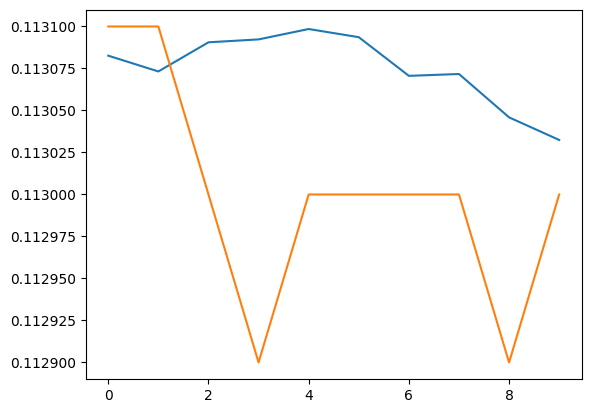

In [166]:
pd.Series(yprice_pred[0]).plot()
pd.Series(y_true_local[y_true_local['window_id']==1]['close']).plot()

In [ ]:
r, c = yprice_pred.shape

out = pd.DataFrame({
    "window_id": np.repeat(np.arange(r), c)+1,
    "time_step": np.tile(np.arange(c), r),
    'pred_close': yprice_pred.ravel(order="C")
})

In [39]:
x_test

,window_id,time_step,close,volume
0,1,0,0.1126,24976.0
1,1,1,0.1126,0.0
2,1,2,0.1125,2299.0
3,1,3,0.1124,287909.0
4,1,4,0.1123,22738.0
...,...,...,...,...
2999995,50000,55,0.1702,456740.0
2999996,50000,56,0.1701,487518.0
2999997,50000,57,0.1700,378209.0
2999998,50000,58,0.1698,145809.0


In [35]:
pred_local

,window_id,time_step,pred_close
0,1,0,0.135550
1,1,1,0.135536
2,1,2,0.135527
3,1,3,0.135518
4,1,4,0.135505
5,1,5,0.135493
6,1,6,0.135485
7,1,7,0.135482
8,1,8,0.135478
9,1,9,0.135474


<Axes: xlabel='None,time_step'>

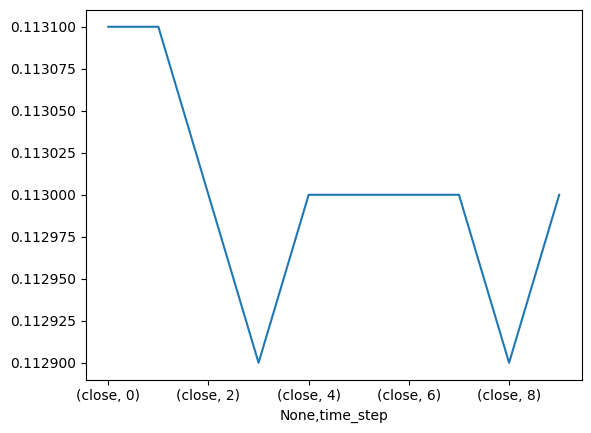

In [38]:
y_true_local.set_index(['window_id','time_step']).unstack().T[1].plot()

In [34]:
train_ds.y

array([[0.13562, 0.13518, 0.13517, ..., 0.13587, 0.13578, 0.13546],
       [0.13518, 0.13517, 0.13534, ..., 0.13578, 0.13546, 0.13547],
       [0.13517, 0.13534, 0.1354 , ..., 0.13546, 0.13547, 0.13555],
       ...,
       [0.1787 , 0.17897, 0.17934, ..., 0.17898, 0.17895, 0.17881],
       [0.17897, 0.17934, 0.1795 , ..., 0.17895, 0.17881, 0.17861],
       [0.17934, 0.1795 , 0.1795 , ..., 0.17881, 0.17861, 0.17844]],
      shape=(100000, 10), dtype=float32)

In [123]:
from dataclasses import dataclass, asdict
state = {
    "alpha": model.alpha,
    "feature_config": asdict(model.feature_builder.cfg),
    "scaler": model.scaler,
    "model": model.model,
    "feature_names": model.feature_names_,
}

import joblib
joblib.dump(state, "/home/pduce/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit/submissions/ridge/model_weights.pkl")

['/home/pduce/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit/submissions/ridge/model_weights.pkl']